Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler

import os
import requests

Загружаем датасет

In [2]:
file_data = "parkinsons.data"
file_names = "parkinsons.names"

file_data_url = "https://storage.yandexcloud.net/academy.ai/practica/"

files_list = [file_data, file_names]

for name in files_list:
    if not os.path.exists(name):
        res = requests.get(f"{file_data_url}{name}")
        with open(name, "wb") as file:
            file.write(res.content)
        
        print(f"{name} загружен")
    else:
        print(f"{name} уже существует")
        

parkinsons.data уже существует
parkinsons.names уже существует


In [3]:
data = pd.read_csv("parkinsons.data", delimiter=",")

Посмотрим на него

In [4]:
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [6]:
for colum in data.columns:
    print(colum)

name
MDVP:Fo(Hz)
MDVP:Fhi(Hz)
MDVP:Flo(Hz)
MDVP:Jitter(%)
MDVP:Jitter(Abs)
MDVP:RAP
MDVP:PPQ
Jitter:DDP
MDVP:Shimmer
MDVP:Shimmer(dB)
Shimmer:APQ3
Shimmer:APQ5
MDVP:APQ
Shimmer:DDA
NHR
HNR
status
RPDE
DFA
spread1
spread2
D2
PPE


Удалим не нужную колонку names

In [7]:
data = data.drop(columns=['name'])

Проверим есть ли Nan значения

In [8]:
data.isna().sum()

MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

Проверим есть ли дубликаты

In [9]:
data.duplicated().sum()

0

Посмотрим сбалансированы ли данные

<Axes: ylabel='count'>

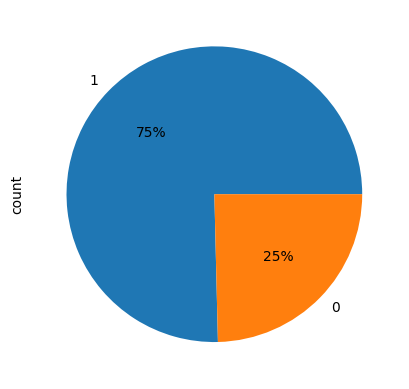

In [10]:
data['status'].value_counts().plot(kind='pie', autopct = "%1.0f%%")

In [11]:
data['status'].value_counts()

status
1    147
0     48
Name: count, dtype: int64

Мы видим, что наши данные не сбалансированы. имеем 75% (147 строк) для метки 1 и 25% (48 строк) для метки 0. Попробуем их сбалансировать

Укажем метки

In [12]:
X = data.drop("status", axis=1)
y = data["status"]

Сбалансируем их с помощью RandomOverSampler, увеличивая количество образцов в меньшем классе до 60% от количества образцов в большем классе

In [13]:
sample = RandomOverSampler(sampling_strategy=0.6)
X_sample, y_sample = sample.fit_resample(X, y)

<Axes: ylabel='count'>

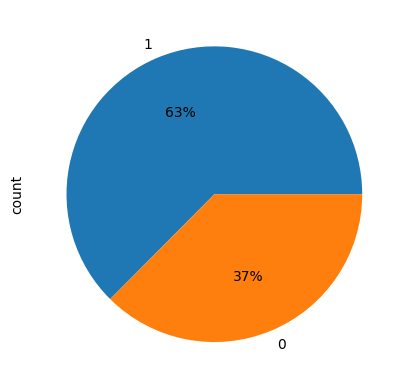

In [14]:
y_sample.value_counts().plot(kind='pie', autopct = "%1.0f%%")

In [15]:
y_sample.value_counts()

status
1    147
0     88
Name: count, dtype: int64

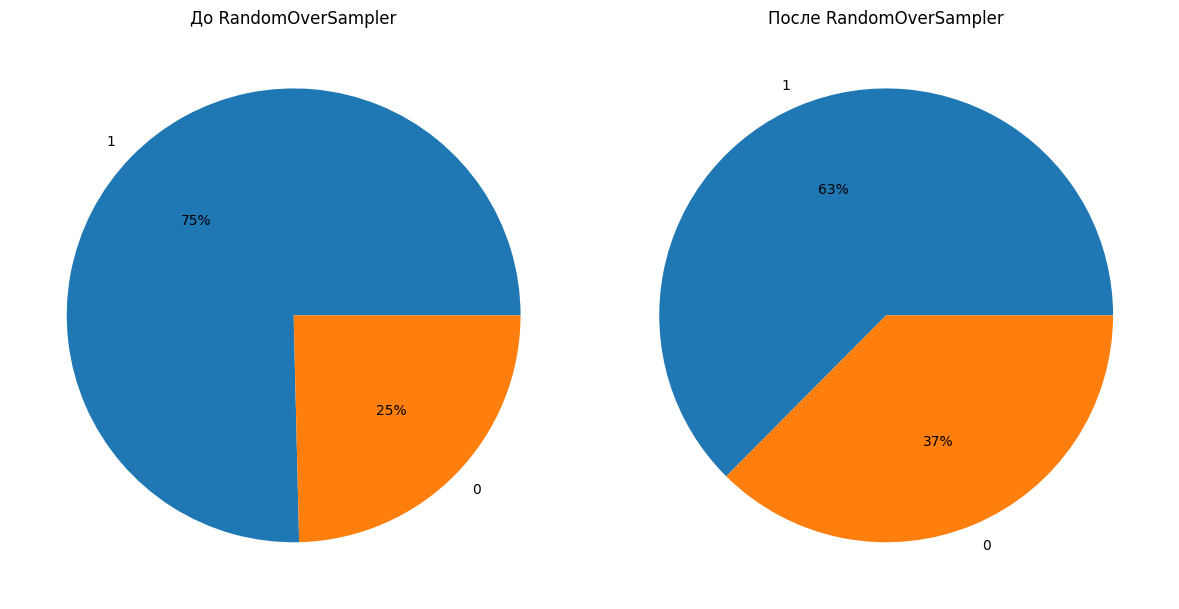

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Первый подграфик
data['status'].value_counts().plot(kind='pie', autopct="%1.0f%%")
plt.title('До RandomOverSampler')
plt.ylabel('')

plt.subplot(1, 2, 2)  # Второй подграфик
y_sample.value_counts().plot(kind='pie', autopct="%1.0f%%")
plt.title('После RandomOverSampler')
plt.ylabel('')

plt.tight_layout()
plt.show()

Нам удалось немного сбалансировать данные

Приступим к обучению модели.

Для начала разделим датасет на обучающий и тестовый наборы данных в пропорции 80:20

In [17]:
X_train , X_test, y_train , y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

Нормализуем признаки при помощи MinMaxScaler. Так мы масштабируем признаки, чтобы они находились в определенном диапазоне

In [18]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучим модель с использованием сетки гиперпараметров.

* n_estimators - количество деревьев
* max_depth - максимальная глубина дерева
* learning_rate - скорость обучения
* gamma - коэффициент регуляризации

In [19]:
xgb_classifier = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

Получаем наилучшую модель

In [20]:
best_xgb_classifier = grid_search.best_estimator_

Проверяем точность на тестовом наборе

In [21]:
y_pred = best_xgb_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 97.87%


Посмотрим матрицу ошибок

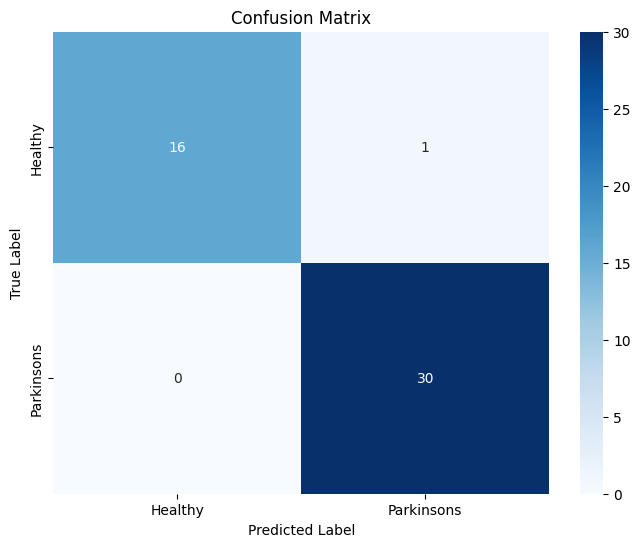

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Healthy', 'Parkinsons'], yticklabels=['Healthy', 'Parkinsons'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()